In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import random                                    
from math import isnan
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
import re
import os


In [29]:

cartella = r'C:\Users\loren\Downloads\progettoSL\scraping'

elenco_file = [file for file in os.listdir(cartella) if file.endswith('.xlsx')]

if not elenco_file:
    print("Nessun file Excel trovato nella cartella.")
else:
    primo_file = os.path.join(cartella, elenco_file[0])
    df_completo = pd.read_excel(primo_file)

    col_name_mapping = {
        'data-ril': 'data_ril',
        'dara_ril': 'data_ril',
        'dati_ril': 'data_ril',
        'aeroproto_partenza': 'aeroporto_partenza',
        'oario_partenza':'orario_partenza',
        'oario_arrivo':'orario_arrivo',
        'orario_arrivp':'orario_arrivo',
        'orario_partenzal':'orario_partenza',
        'orariopartenza':'orario_partenza',
        'orario_partenza ':'orario_partenza',
        'Tariffa': 'tariffa',
        'tariffa ': 'tariffa',
        'tariffa  ': 'tariffa',
        'tariffa   ': 'tariffa',
        'operatore ':'operatore',
        'data_partenza ':'data_partenza',
        'data_ril ':'data_ril'
    }

    for col_old, col_new in col_name_mapping.items():
        if col_old in df_completo.columns:
            df_completo.rename(columns={col_old: col_new}, inplace=True)

    for file in elenco_file[1:]:
        percorso_file = os.path.join(cartella, file)
        df = pd.read_excel(percorso_file)

        for col_old, col_new in col_name_mapping.items():
            if col_old in df.columns:
                df.rename(columns={col_old: col_new}, inplace=True)

        df_completo = pd.concat([df_completo, df], ignore_index=True)

    percorso_output = r'C:\Users\loren\Downloads\progettoSL\dataset.xlsx'

    df_completo.to_excel(percorso_output, index=False)



Features Engineering 

In [3]:
data = pd.read_excel('dataset.xlsx')

In [4]:

data.dropna(inplace = True)

data = data[~data.index.duplicated(keep='first')]

data = data[~data['orario_arrivo'].str.contains('\+1')]
data = data[~data['operatore'].str.contains('Flixbus')]
data = data[~data['operatore'].str.contains('FlixBus')]
data = data[~data['aeroporto_partenza'].str.contains('DBV')]
data = data[~data['operatore'].str.contains('Treno')]
data = data[~data['operatore'].str.contains('Italotreno')]
data = data[~data['operatore'].str.contains('Trenitalia')]
#data = data[~data['operatore'].str.contains('Aeroitalia')]

In [5]:
def clean_price(value):
    if isinstance(value, (int, float)):
        return value
    try:
        new_price = int(re.sub(r'[^\d]', '', str(value)))
        return new_price
    except:
        return None

data['prezzo'] = data['prezzo'].apply(clean_price)
#data.dropna(subset=['prezzo'], inplace=True)


In [6]:
def transform_row(row):
    if row['tipo'] == 'diretto':
        row['tipo'] = 0
    elif row['tipo'] == '1 scalo' or row['tipo'] == '1 cambio':
        row['tipo'] = 1
    return row

data = data.apply(transform_row, axis=1)


In [7]:
def convert_hours_minutes_to_minutes(duration_str):
    match = re.match(r'(\d+)h (\d+)m', duration_str)
    
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        total_minutes = hours * 60 + minutes
        return total_minutes
    else:
        return None

for i in data.index:
    duration_str = data.loc[i, 'durata']
    if isinstance(duration_str, str):
        new_duration = convert_hours_minutes_to_minutes(duration_str)
        data.loc[i, 'durata'] = new_duration

In [8]:

data['tariffa'] = data['tariffa'].replace({'Tariffa Standard': 'Standard', 'Tariffa di base': 'Standard', 'Economy Light': 'Light'})
data['tariffa'] = data['tariffa'].replace({'Economy Saver': 'Economy', 'Economy Flex': 'Economy', 'Economy Standard': 'Economy', 'Economy Classic': 'Economy'})
data['tariffa'] = data['tariffa'].replace({'Business Flessibile': 'Business', 'Business Flex': 'Business', 'Business Light': 'Business', 'Business Optimal': 'Business', 'Business Promozionale': 'Business','Business Saver': 'Business'})
data['tariffa'] = data['tariffa'].replace({'Standard Economy': 'Standard', 'Tariffa flessibile': 'Flex', 'Flessibile': 'Flex', 'Basic Economy':'Basic'})
data['tariffa'] = data['tariffa'].replace({'Classic': 'Standard', 'Discount': 'Economy', 'EcoFly': 'Economy','Saver':'Economy','Smart':'Economy','LowFare':'Economy','Light':'Economy','Basic':'Economy','Optimal':'Economy','Flex':'Economy'})
data['tariffa'] = data['tariffa'].replace({'Saga Premium': 'Business', 'Plus': 'Business', 'Prima classe': 'Business', 'Executive': 'Business'})
dummies_tariffa = pd.get_dummies(data['tariffa'], prefix='tariffa')

data = pd.concat([data, dummies_tariffa], axis=1)
data = data.drop('tariffa', axis=1)


In [9]:
data['aeroporto_partenza'] = data['aeroporto_partenza'].replace({'ROM': 'FCO'})
dummies_aeroporto_partenza = pd.get_dummies(data['aeroporto_partenza'], prefix='aeroporto_partenza')


dummies_aeroporto_arrivo = pd.get_dummies(data['aeroporto_arrivo'], prefix='aeroporto_arrivo')
data = pd.concat([data, dummies_aeroporto_partenza, dummies_aeroporto_arrivo], axis=1)
data = data.drop(['aeroporto_partenza', 'aeroporto_arrivo'], axis=1)

# dummies_operatore = pd.get_dummies(data['operatore'], prefix='operatore')

# data = pd.concat([data, dummies_operatore], axis=1)
data['operatore'] = data['operatore'].replace({'easyJet Europe': 'easyJet'})
data['operatore'] = data['operatore'].replace({'Ryanair UK': 'Ryanair'})
data['operatore'] = data['operatore'].replace({'Transavia France': 'Transavia'})
data.loc[data['operatore'].str.contains(','), 'operatore'] = 'Multiple_Operator'
dummy_operators = data['operatore'].str.get_dummies()
data = pd.concat([data, dummy_operators], axis=1)

data = data.drop('operatore', axis=1)


In [10]:
data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'], utc=True)


In [11]:
data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'])


data['partenza_0-8'] = (data['orario_partenza'].dt.hour >= 0) & (data['orario_partenza'].dt.hour < 8)
data['partenza_8-16'] = (data['orario_partenza'].dt.hour >= 8) & (data['orario_partenza'].dt.hour < 16)
data['partenza_16-24'] = (data['orario_partenza'].dt.hour >= 16) & (data['orario_partenza'].dt.hour < 24)


data['arrivo_0-8'] = (data['orario_arrivo'].dt.hour >= 0) & (data['orario_arrivo'].dt.hour < 8)
data['arrivo_8-16'] = (data['orario_arrivo'].dt.hour >= 8) & (data['orario_arrivo'].dt.hour < 16)
data['arrivo_16-24'] = (data['orario_arrivo'].dt.hour >= 16) & (data['orario_arrivo'].dt.hour < 24)


data['partenza_0-8'] = data['partenza_0-8'].astype(int)
data['partenza_8-16'] = data['partenza_8-16'].astype(int)
data['partenza_16-24'] = data['partenza_16-24'].astype(int)

data['arrivo_0-8'] = data['arrivo_0-8'].astype(int)
data['arrivo_8-16'] = data['arrivo_8-16'].astype(int)
data['arrivo_16-24'] = data['arrivo_16-24'].astype(int)


In [12]:

def map_numero_giorno(numero_giorno):
    if 24 <= numero_giorno <= 31:
        return 1
    elif 1 <= numero_giorno <= 7:
        return 2
    elif 8 <= numero_giorno <= 15:
        return 3
    else:
        return None 

data['giorno_settimana'] = data['data_partenza'].apply(lambda x: x.split()[0])
data['numero_giorno'] = data['data_partenza'].apply(lambda x: int(x.split()[1].split('/')[0]))
data['numero_mese'] = data['data_partenza'].apply(lambda x: int(x.split('/')[1]))

data['colonna_personalizzata'] = data['numero_giorno'].apply(map_numero_giorno)


giorno_settimana_dummy = pd.get_dummies(data['giorno_settimana'])
settimana_dummy = pd.get_dummies(data['colonna_personalizzata'], prefix='settimana')
mese_dummy = pd.get_dummies(data['numero_mese'], prefix='mese')


data = pd.concat([data, giorno_settimana_dummy, settimana_dummy, mese_dummy], axis=1)


data.drop(['giorno_settimana', 'numero_giorno', 'numero_mese', 'colonna_personalizzata'], axis=1, inplace=True)


In [13]:
df = pd.DataFrame(data)
# Funzione per convertire il formato delle date nella colonna 'data_ril'
def converti_data(data):
    giorni_settimana = {'lun': 'Mon', 'mar': 'Tue', 'mer': 'Wed', 'gio': 'Thu', 'ven': 'Fri', 'sab': 'Sat', 'dom': 'Sun'}
    for giorno in giorni_settimana:
        data = data.replace(giorno, giorni_settimana[giorno])

    data = data.replace('\\', '/').replace('\'', '')
    return data

# Funzione per estrarre solo il formato '24/7' dalla colonna 'data_partenza'
def estrai_data_partenza(data):
    return data.split()[1]

# Applica le funzioni alle colonne 'data_partenza' e 'data_ril' del DataFrame 'data'
data['data_partenza'] = data['data_partenza'].apply(estrai_data_partenza)
data['data_ril'] = data['data_ril'].apply(converti_data)


0        24/7
1        24/7
2        24/7
3        24/7
4        24/7
         ... 
86485    20/8
86486    20/8
86487    20/8
86491    20/8
86492    20/8
Name: data_partenza, Length: 76122, dtype: object
0        21/6
1        21/6
2        21/6
3        21/6
4        21/6
         ... 
86485    18/7
86486    18/7
86487    18/7
86491    18/7
86492    18/7
Name: data_ril, Length: 76122, dtype: object


In [14]:
# def format_date_partenza(date_str):
#     date_match = re.search(r'\d+/\d+', date_str)
#     if date_match:
#         date_obj = datetime.strptime(date_match.group(), '%d/%m')
#         return date_obj.strftime('%d/%m')
#     else:
#         return None

# def format_date_rilevato(date_str):
    
#     date_match = re.search(r'\d+\\\d+', date_str)
#     if date_match:
#         date_obj = datetime.strptime(date_match.group(), '%d\\%m')
#         return date_obj.strftime('%d/%m')
#     else:
#         return None

def calculate_date_difference(date_partenza, date_rilevato):
    
    if date_partenza is None or date_rilevato is None:
        return None

    
    date_partenza_obj = datetime.strptime(date_partenza, '%d/%m')
    date_rilevato_obj = datetime.strptime(date_rilevato, '%d/%m')

    
    diff_days = (date_rilevato_obj.replace(year=date_partenza_obj.year) - date_partenza_obj).days

    return abs(diff_days) 

# data['data_partenza'] = data['data_partenza'].apply(format_date_partenza)
# data['data_ril'] = data['data_ril'].apply(format_date_rilevato)


data['differenza_giorni'] = data.apply(lambda row: calculate_date_difference(row['data_partenza'], row['data_ril']), axis=1)



In [15]:
conteggio_celle_vuote = data['differenza_giorni'].isnull().sum()

print("Numero di celle vuote nella colonna 'differenza_giorni':", conteggio_celle_vuote)

Numero di celle vuote nella colonna 'differenza_giorni': 0


In [20]:
import pandas as pd

# Definisci le soglie per ciascuna dummy variable
thresholds = [1, 3, 7, 15, 30, 60]

# Aggiungi una colonna con le categorie corrispondenti agli intervalli
data['interval'] = pd.cut(data['differenza_giorni'], bins=[0] + thresholds + [float('inf')])

# Crea le dummy variables utilizzando pd.get_dummies
dummy_columns = pd.get_dummies(data['interval'], prefix='dummy')

# Concatena le dummy variables al DataFrame originale
data = pd.concat([data, dummy_columns], axis=1)


In [29]:
import pandas as pd

# Assume che 'data' sia il tuo DataFrame
# Itera attraverso tutte le colonne e controlla se contengono datetime con fuso orario
for col in data.columns:
    if pd.api.types.is_datetime64tz_dtype(data[col]):
        data[col] = data[col].dt.tz_localize(None)  # Converti in "timezone unaware"

output_file = "Voli.xlsx"
data.to_excel(output_file, index=False)


## Outliers removal

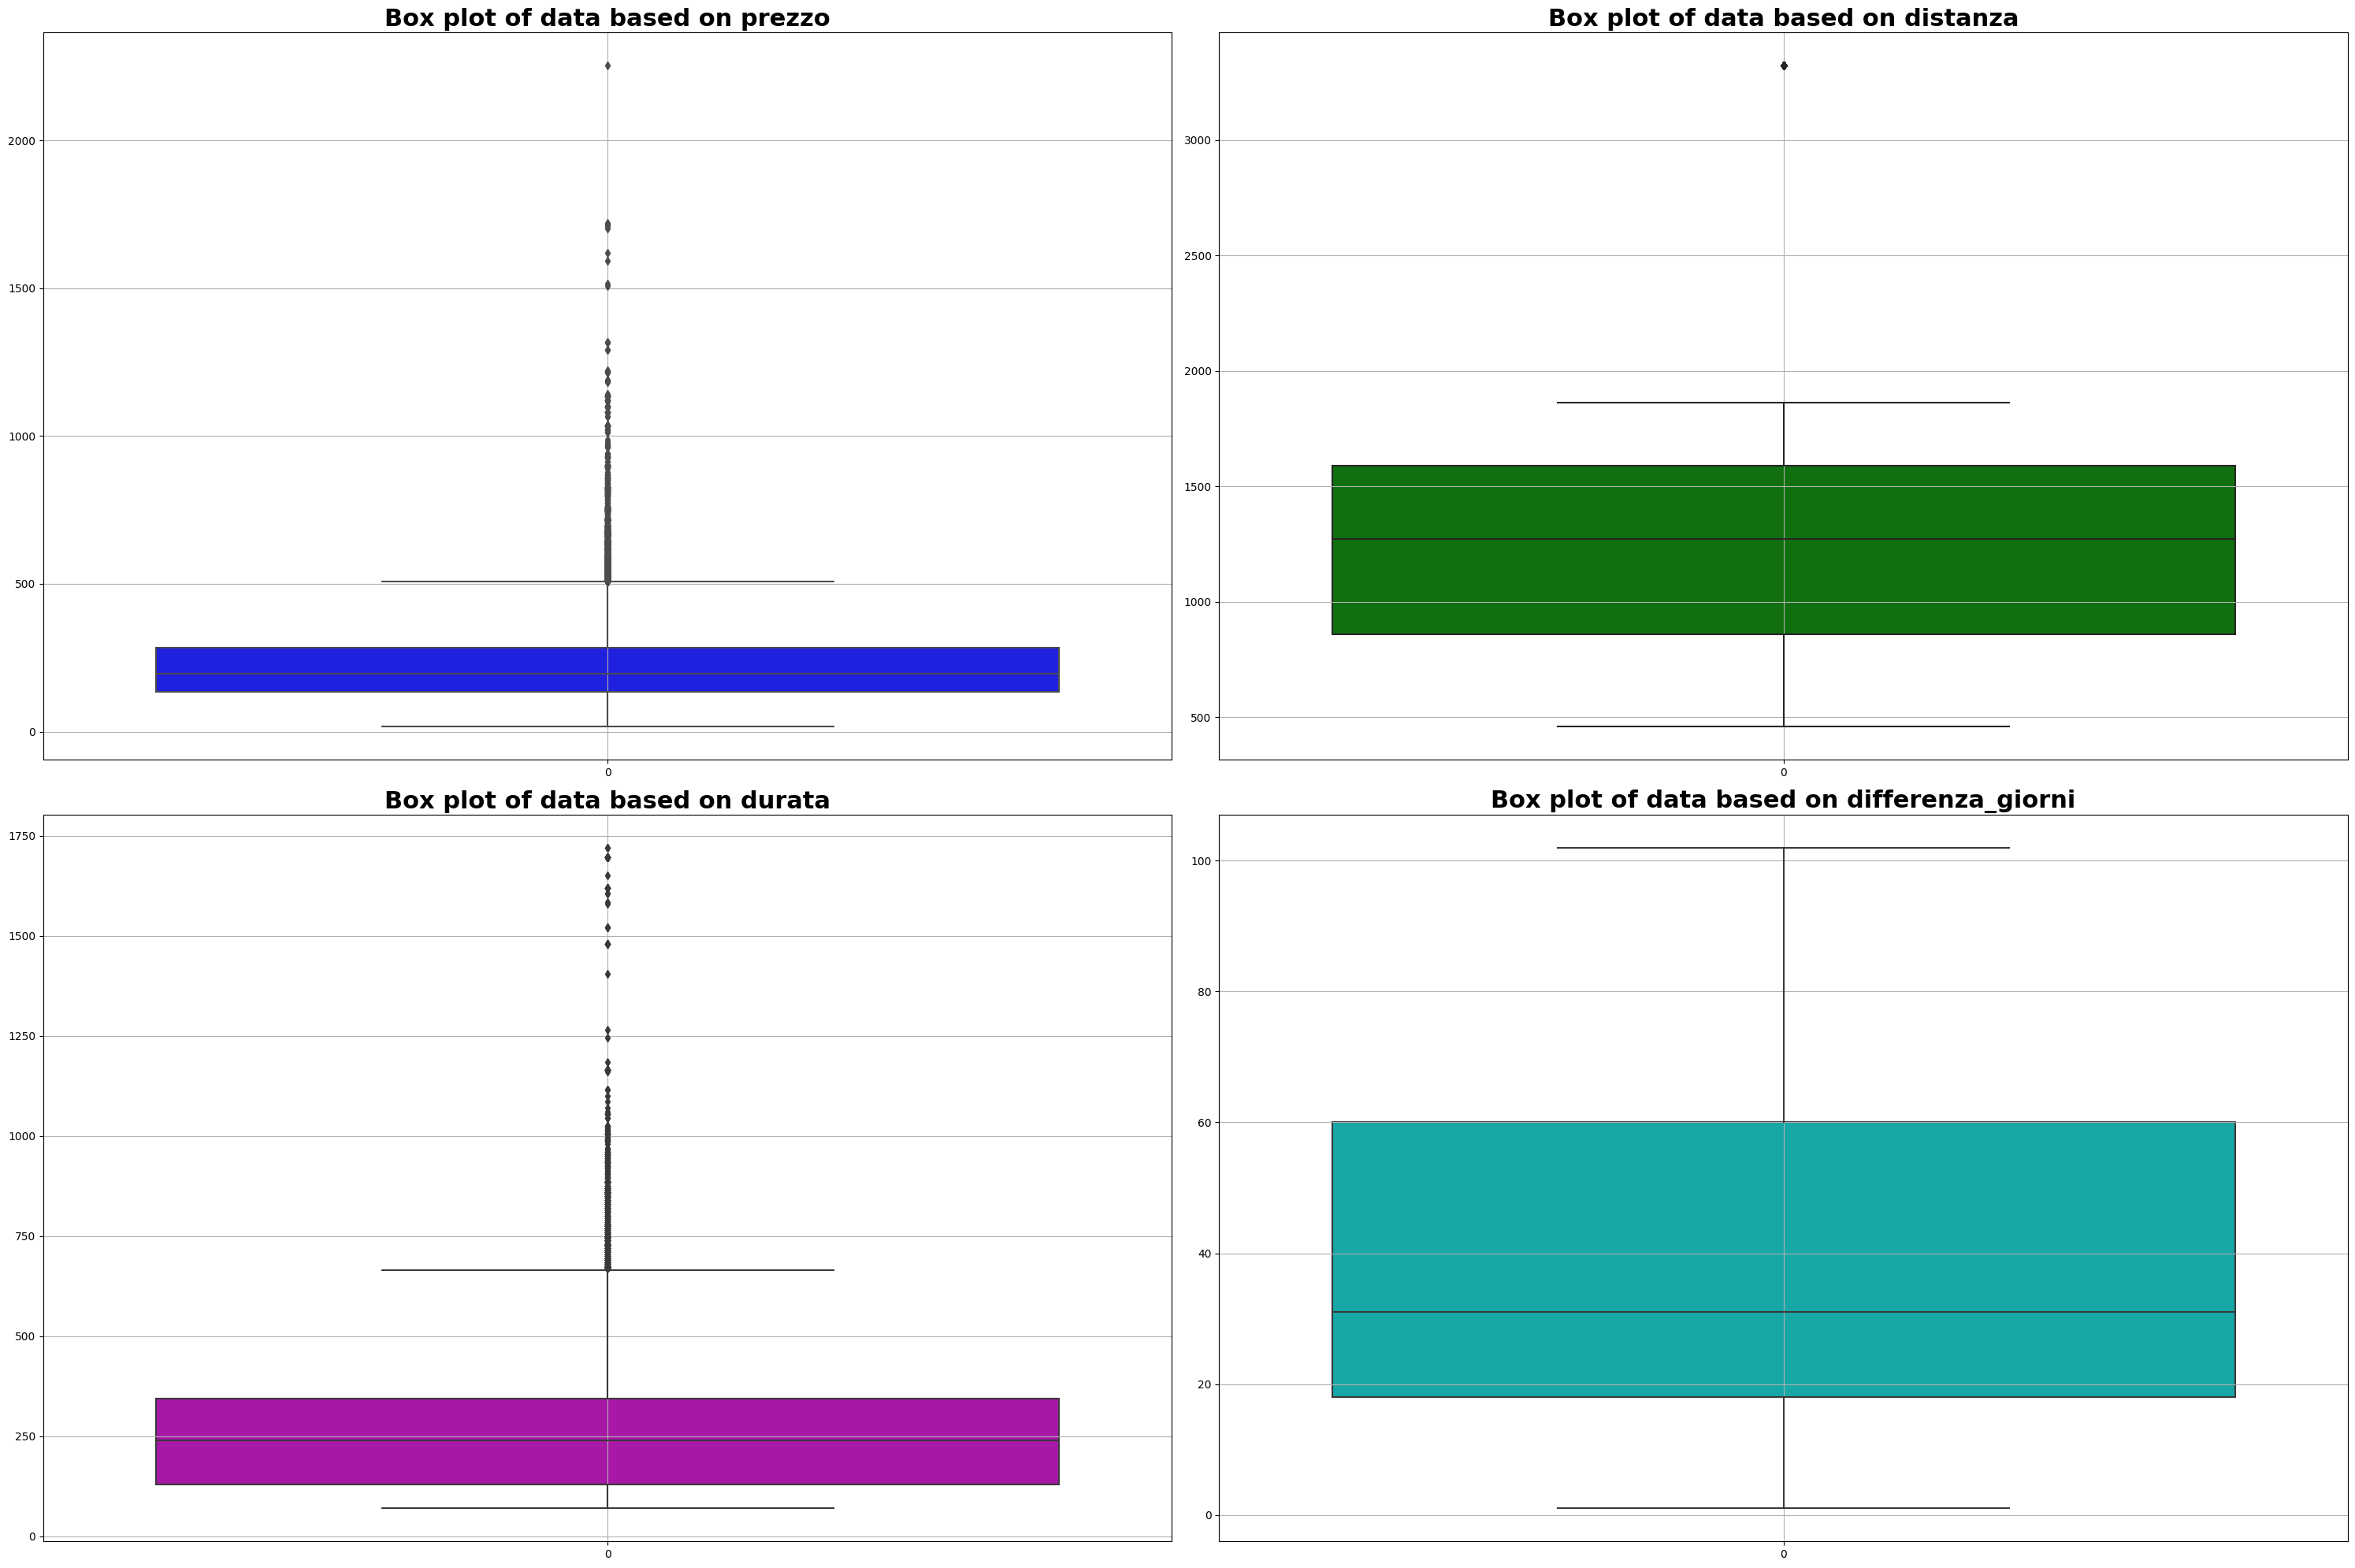

In [9]:
# Box-plots of some principal, non-binary, features. As already seen, on the right side of the plots we notice several outliers
data = pd.read_excel('Voli.xlsx')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 20))
features = ['prezzo','distanza','durata', 'differenza_giorni']
colors = ['b', 'g', 'm','c'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(2):
    k = row_idx
    for col_idx in range(2): 
        current = axes[row_idx, col_idx]
        target = row_idx + col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [10]:
upper_bound_price = np.percentile(data.loc[:, 'prezzo'], 95)
upper_bound_dimension = np.percentile(data.loc[:, 'durata'], 95)

In [11]:
# We now drop some of the outliers (the 5% with the highest dimensions and prices)

for i in data.index:
    if data.loc[i, 'prezzo'] > upper_bound_price:
        data = data.drop(i)
        continue
    if data.loc[i, 'durata'] > upper_bound_dimension:
        data = data.drop(i)

In [12]:
# Since we still have outliers, which could compromise our model performances, we proceed with a log-normalization of data
# APPLICATION OF LOG NORMALIZATION

for j in data.columns:  
    if set(data.loc[:, j]) != {0,1}:
        for i in data.index: 
                try:
                    data.loc[i, j] = np.sign(data.loc[i,j]) * np.log(np.absolute(data.loc[i, j]) + 1 )
                except:
                    continue

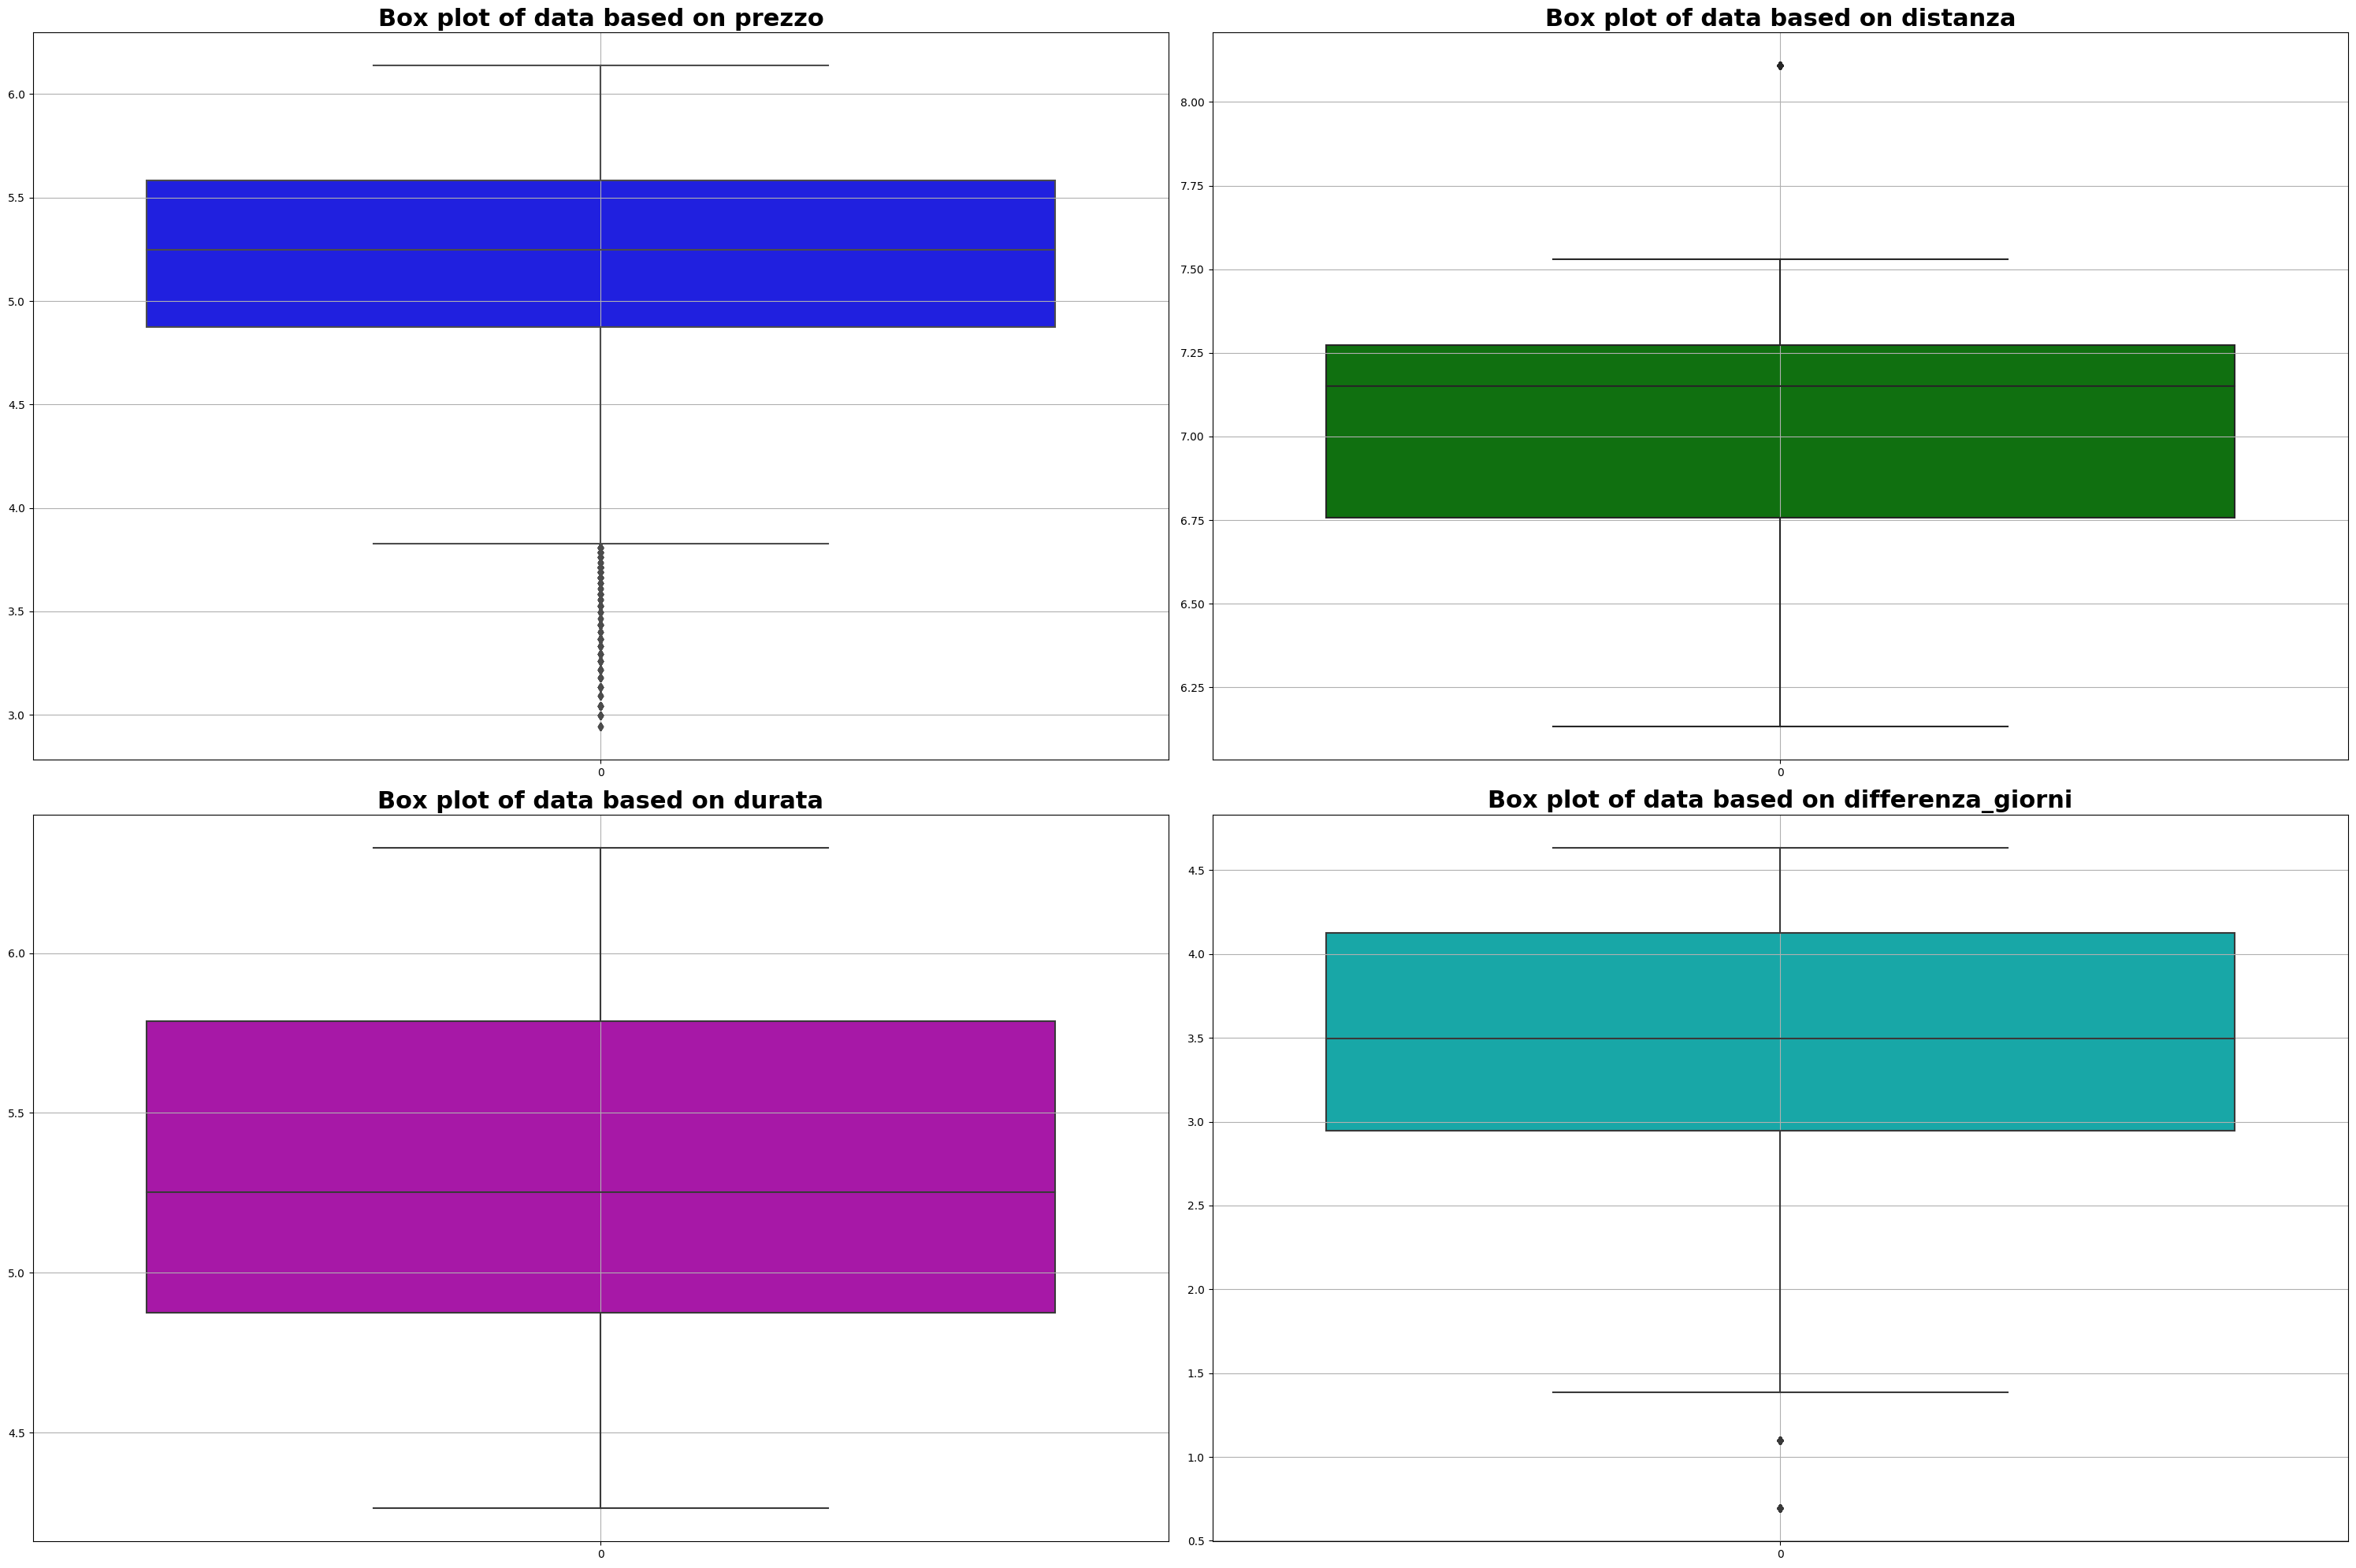

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 20))
features = ['prezzo','distanza','durata', 'differenza_giorni']
colors = ['b', 'g', 'm','c'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(2):
    k = row_idx
    for col_idx in range(2): 
        current = axes[row_idx, col_idx]
        target = row_idx + col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [82]:
def get_column_names(file_name):
    try:
        # Carica il file Excel in un DataFrame
        df = pd.read_excel(file_name)

        # Ottieni i nomi delle colonne e li inserisci in una lista
        column_names = df.columns.tolist()

        return column_names

    except Exception as e:
        print("Si è verificato un errore:", str(e))
        return []

# Specifica il percorso del tuo file Excel
file_path = "Datasett.xlsx"

# Chiama la funzione e ottieni la lista dei nomi delle colonne
column_names_list = get_column_names(file_path)

# Stampa la lista dei nomi delle colonne
print("Nomi delle colonne:", column_names_list)


Nomi delle colonne: ['tipo', 'durata', 'prezzo', 'distanza', 'tariffa_Business', 'tariffa_Economy', 'tariffa_Miste', 'tariffa_Standard', 'aeroporto_partenza_CIA', 'aeroporto_partenza_FCO', 'aeroporto_arrivo_AMS', 'aeroporto_arrivo_ATH', 'aeroporto_arrivo_BCN', 'aeroporto_arrivo_BVA', 'aeroporto_arrivo_CDG', 'aeroporto_arrivo_CPH', 'aeroporto_arrivo_DBV', 'aeroporto_arrivo_EIN', 'aeroporto_arrivo_IBZ', 'aeroporto_arrivo_JMK', 'aeroporto_arrivo_JNX', 'aeroporto_arrivo_JTR', 'aeroporto_arrivo_KEF', 'aeroporto_arrivo_LCY', 'aeroporto_arrivo_LGW', 'aeroporto_arrivo_LHR', 'aeroporto_arrivo_LIS', 'aeroporto_arrivo_LTN', 'aeroporto_arrivo_MLA', 'aeroporto_arrivo_NCE', 'aeroporto_arrivo_ORY', 'aeroporto_arrivo_PAR', 'aeroporto_arrivo_STN', 'aeroporto_arrivo_SVQ', 'Aegean Airlines', 'Air Corsica', 'Air Europa', 'Air France', 'Air Malta', 'Air Serbia', 'Austrian Airlines', 'British Airways', 'Brussels Airlines', 'Bulgaria Air', 'CitizenPlane', 'Croatia Airlines', 'Eurowings', 'Finnair', 'Hahn Air

In [30]:
data = pd.read_excel('Voli.xlsx')


In [95]:


columns_to_count = data.loc[:, 'Aegean Airlines':'easyJet']

# Conta quanti 1 ci sono in ciascuna colonna
count_of_ones_per_column = columns_to_count.sum()

# Stampa i risultati
print(count_of_ones_per_column)


Aegean Airlines           2179
Air Corsica                 78
Air Europa                 244
Air France                1576
Air Malta                  953
Air Serbia                 363
Austrian Airlines          283
British Airways            701
Brussels Airlines          187
Bulgaria Air                 9
CitizenPlane                49
Croatia Airlines            99
Eurowings                  782
Finnair                    114
Hahn Air Systems           790
ITA Airways               8352
Iberia                    4793
Icelandair                 321
Jet2                       229
KLM                       3319
LOT                          3
Lufthansa                 3650
Multiple_Operator        16453
Neos Air                    89
Norwegian                  839
Pegasus Airlines            24
Ryanair                   5710
SWISS                      841
Scandinavian Airlines     1215
Sky Express               1294
Smartwings                  49
TAP AIR PORTUGAL          1458
Transavi

In [18]:
data = pd.read_excel('Voli.xlsx')
columns_to_count = data.loc[:, 'Aegean Airlines':'easyJet']

# Conta quanti 1 ci sono in ciascuna colonna
count_of_ones_per_column = columns_to_count.sum()

# Calcola le statistiche descrittive
stats_desc = count_of_ones_per_column.describe()
# Calcola le statistiche descrittive
stats_desc = count_of_ones_per_column.describe(percentiles=[.25, .75])

# Calcola l'IQR
Q1 = stats_desc[4]  # 25th percentile
Q3 = stats_desc[6]  # 75th percentile
IQR = Q3 - Q1

# Identifica gli outliers
outliers = count_of_ones_per_column[
    (count_of_ones_per_column < Q1 - 1.5 * IQR) |
    (count_of_ones_per_column > Q3 + 1.5 * IQR)
]

# Rimuovi gli outliers
data_cleaned = data.drop(columns=outliers.index)

# Stampa gli outliers rimossi
print("Outliers rimossi:")
print(outliers)


# Ora puoi utilizzare 'data_cleaned' per le tue analisi senza gli outliers


Outliers rimossi:
ITA Airways           8352
Iberia                4793
Multiple_Operator    16453
Ryanair               5710
Vueling              10769
dtype: int64


## Features Selection

(76121, 94) (76121,)
[5.00501800e-01 4.15284881e-01 9.29103607e-05 2.58601325e-02
 4.06497803e-09 9.39077080e-06 0.00000000e+00 1.35995140e-05
 2.29231311e-05 1.99769509e-05 1.61427379e-04 6.77140217e-05
 1.71223502e-04 8.43205807e-06 2.85001639e-05 3.80947988e-05
 5.08433320e-05 2.17440827e-07 2.00972244e-05 9.96917518e-05
 9.73880179e-06 7.46689398e-05 3.54447507e-02 3.11990133e-08
 6.97615861e-04 1.92311389e-05 1.73354520e-03 5.15823983e-08
 2.11868581e-04 1.49948019e-04 6.39491643e-05 4.40346754e-09
 6.22111968e-05 8.48810702e-04 4.36589387e-06 1.16180608e-04
 1.54105852e-06 5.37259133e-07 1.17803805e-06 2.79040892e-09
 6.72704881e-05 1.74258196e-07 2.87488545e-07 0.00000000e+00
 0.00000000e+00 1.46668166e-09 6.46999760e-05 1.02997717e-06
 8.63557025e-05 2.49421233e-04 8.66915551e-06 1.56324332e-05
 2.17406228e-06 2.03764929e-05 0.00000000e+00 1.06424260e-04
 1.02834085e-04 0.00000000e+00 1.32421351e-05 0.00000000e+00
 6.31528154e-06 2.54123960e-06 9.18626372e-05 9.33123590e-04
 3.

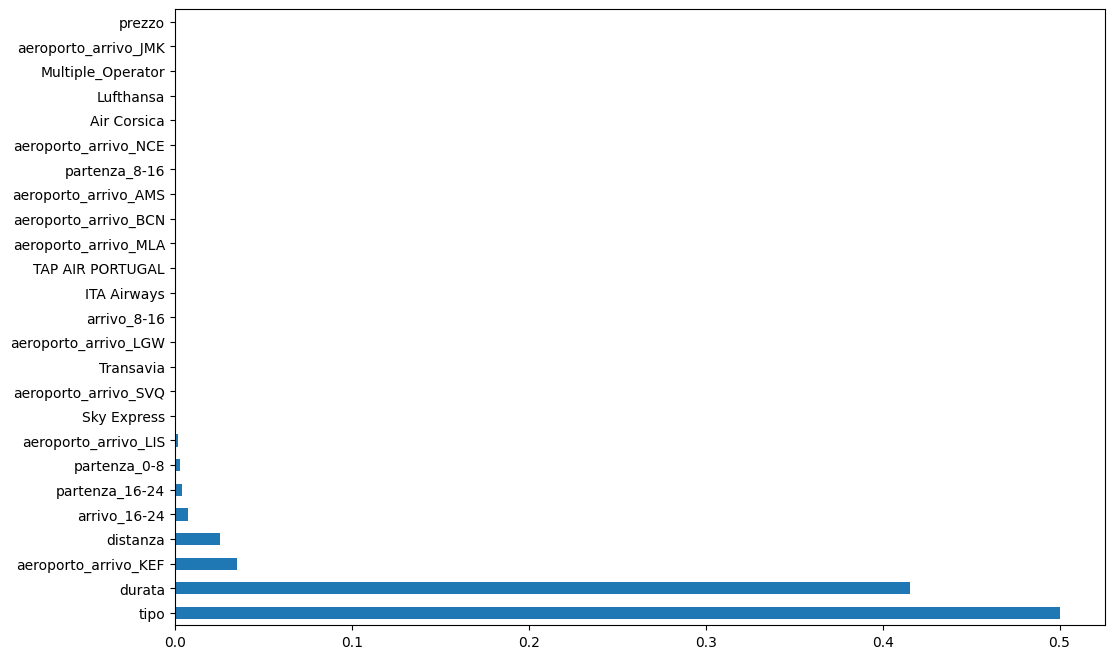

In [86]:
X = data.loc[:, ['tipo', 'durata', 'prezzo', 'distanza', 'tariffa_Business', 'tariffa_Economy', 
'tariffa_Miste', 'tariffa_Standard', 'aeroporto_partenza_CIA', 'aeroporto_partenza_FCO', 'aeroporto_arrivo_AMS', 'aeroporto_arrivo_ATH',
'aeroporto_arrivo_BCN', 'aeroporto_arrivo_BVA', 'aeroporto_arrivo_CDG', 'aeroporto_arrivo_CPH', 'aeroporto_arrivo_DBV', 'aeroporto_arrivo_EIN',
'aeroporto_arrivo_IBZ', 'aeroporto_arrivo_JMK', 'aeroporto_arrivo_JNX', 'aeroporto_arrivo_JTR', 'aeroporto_arrivo_KEF', 'aeroporto_arrivo_LCY',
 'aeroporto_arrivo_LGW', 'aeroporto_arrivo_LHR', 'aeroporto_arrivo_LIS', 'aeroporto_arrivo_LTN', 'aeroporto_arrivo_MLA', 'aeroporto_arrivo_NCE', 
 'aeroporto_arrivo_ORY', 'aeroporto_arrivo_PAR', 'aeroporto_arrivo_STN', 'aeroporto_arrivo_SVQ', 'Aegean Airlines', 'Air Corsica', 'Air Europa', 
 'Air France', 'Air Malta', 'Air Serbia', 'Austrian Airlines', 'British Airways', 'Brussels Airlines', 'Bulgaria Air', 'CitizenPlane',
  'Croatia Airlines', 'Eurowings', 'Finnair', 'Hahn Air Systems', 'ITA Airways', 'Iberia', 'Icelandair', 'Jet2', 'KLM', 'LOT', 'Lufthansa', 
  'Multiple_Operator', 'Neos Air', 'Norwegian', 'Pegasus Airlines', 'Ryanair', 'SWISS', 'Scandinavian Airlines', 'Sky Express', 'Smartwings', 
  'TAP AIR PORTUGAL', 'Transavia', 'Tunisair', 'Turkish Airlines', 'Volotea', 'Vueling', 'Wizz Air', 'Wizz Air Malta', 'airBaltic', 'easyJet',
   'partenza_0-8', 'partenza_8-16', 'partenza_16-24', 'arrivo_0-8', 'arrivo_8-16', 'arrivo_16-24', 'dom', 'gio', 'lun', 'mar', 'mer', 'sab', 'ven',
    'settimana_1.0','settimana_2.0', 'settimana_3.0', 'mese_7', 'mese_8', 'differenza_giorni']]
y = data.iloc[:, 1]
print(X.shape, y.shape)

# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)
print(selection.feature_importances_)

# Plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [97]:
import pandas as pd
import numpy as np
import xlsxwriter

# Carica il file Excel
file_path = "Datasett.xlsx"
df = pd.read_excel(file_path)

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Estrai la correlazione tra il prezzo e le altre features
price_correlation = correlation_matrix['prezzo']

# Crea un nuovo file Excel
output_file = "matrice_correlazione.xlsx"
workbook = xlsxwriter.Workbook(output_file)
worksheet = workbook.add_worksheet()

# Scrivi i titoli delle colonne
worksheet.write_row('A1', ['Feature', 'Correlazione con Prezzo'])

# Scrivi i dati della matrice di correlazione nel file Excel
for i, (feature, correlation) in enumerate(price_correlation.items(), start=1):
    worksheet.write(i, 0, feature)
    worksheet.write(i, 1, correlation)

# Chiudi il file Excel
workbook.close()

Matrice di correlazione salvata in 'matrice_correlazione.xlsx'


In [32]:

# Calcolare la matrice di correlazione
correlation_matrix = data[['prezzo', 'durata', 'distanza']].corr()

# Stampa la matrice di correlazione
print(correlation_matrix)


            prezzo    durata  distanza
prezzo    1.000000  0.229555  0.358249
durata    0.229555  1.000000  0.412321
distanza  0.358249  0.412321  1.000000


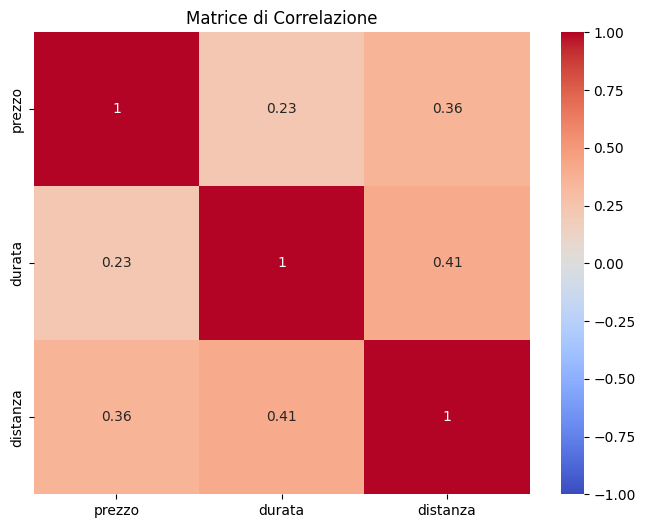

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creare la heatmap della matrice di correlazione
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione')
plt.show()


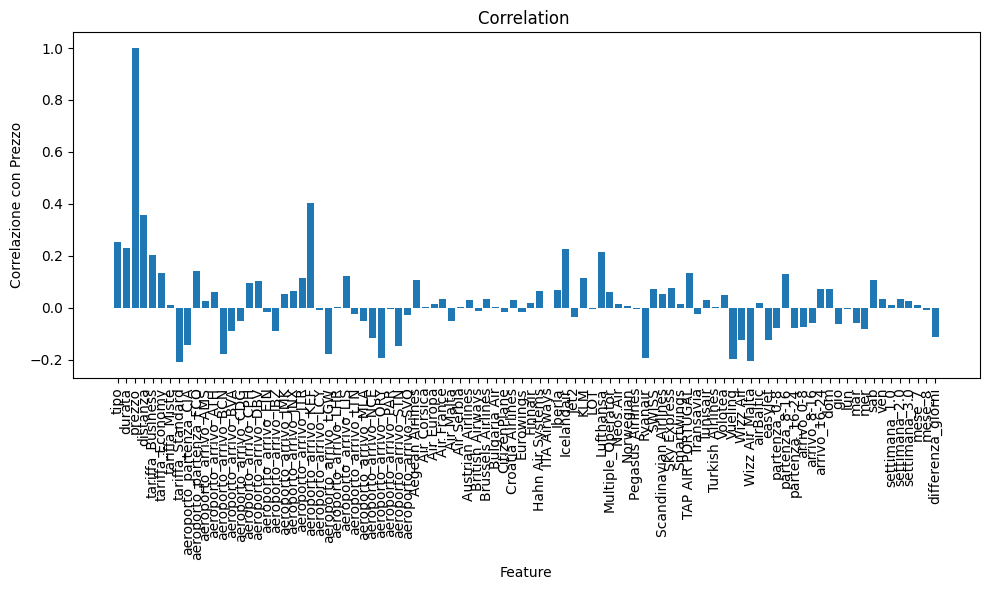

In [99]:
# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.bar(price_correlation.index, price_correlation.values)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Correlazione con Prezzo')
plt.title('Correlation ')
plt.tight_layout()

# Mostra il grafico
plt.show()

In [87]:
# Checking for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    # Calculating Variable Inflation Factor (VIF)
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

# Compute VIF on X
calc_vif(X)

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,tipo,4.843543
1,durata,4.025366
2,prezzo,2.503694
3,distanza,450.898128
4,tariffa_Business,inf
...,...,...
89,settimana_2.0,2.005393
90,settimana_3.0,2.107603
91,mese_7,inf
92,mese_8,inf


In [113]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Supponiamo che 'data' sia il tuo dataframe con le features e il target
# Assicurati che il tuo dataframe includa solo le colonne numeriche e non contenga valori mancanti

# Dividi il dataframe in features (X) e target (y)
X = data.drop(columns=['prezzo'])  # Assumi che il nome della colonna target sia 'target'
y = data['prezzo']

# Dividi i dati in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creiamo un modello Ridge
alpha = 1.0  # Parametro di regolarizzazione
ridge_model = Ridge(alpha=alpha)

# Addestriamo il modello sul training set
ridge_model.fit(X_train, y_train)

# Stampiamo i coefficienti del modello
print("Coefficienti del modello Ridge:")
print(ridge_model.coef_)

# Calcoliamo l'importanza delle features
feature_importance = np.abs(ridge_model.coef_)

# Creiamo un nuovo dataframe per mostrare l'importanza delle features
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Ordiniamo il dataframe per importanza decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Stampiamo l'importanza delle features
print("\nImportanza delle features:")
print(feature_importance_df)

# Valutiamo il modello sul test set
test_score = ridge_model.score(X_test, y_test)
print("\nR^2 score sul test set:", test_score)


Coefficienti del modello Ridge:
[ 3.54964966e+01 -1.31712637e-01 -2.17704264e-02  8.27319535e+01
 -2.46831972e+01  3.13830448e+01 -8.94318011e+01 -9.23353494e-01
  9.23353494e-01 -5.69674832e+00  1.11766062e+01 -6.20483123e+01
 -5.65984005e+01 -6.97267749e+01  4.47822495e+01  2.06468312e+01
 -4.03358023e+01 -2.09468775e+01  4.73893753e+01  2.06297493e+02
  5.45298373e+01  2.76491623e+02 -5.35772129e+01 -4.61048927e+01
 -1.44269908e+01  6.74506223e+01 -7.70401043e+01 -1.61533982e+01
 -7.94094842e+01 -5.85840442e+01 -9.62211419e+01 -5.79197407e+01
  2.60252879e+01  2.88313054e+01 -5.25610878e+00 -3.47954464e+01
  6.74135158e+01 -8.95217745e+01 -4.55016603e+01  2.31807877e+00
  9.15568330e+00  6.83369284e+01  3.41946312e+00 -4.69370748e+01
  3.41896304e+01 -7.63405500e+01 -8.71959650e+01  1.97728358e+01
  3.22299386e+00  9.57194896e+01  2.23694057e+02 -4.65353913e+01
  4.65894370e+01 -4.63721383e+01  6.81752655e+01 -2.00842179e+01
  6.10213107e+00 -4.09207275e+01 -4.69686561e+01 -1.248726

In [88]:
# Defining X and y arrays
X = data.copy()

y = X.loc[:, 'prezzo'].values

X_ = X.drop(['prezzo'], axis = 1).copy()
            
X_ = X_.values



In [89]:
# Defining train and test set and applying standard normalization to data
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.2, random_state = 5)

sc = StandardScaler().fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

media = np.mean(y_train)
dev_st = np.std(y_train)

y_train = (y_train - media) / dev_st
y_test = (y_test - media) / dev_st

X_train = np.c_[np.ones(len(y_train)), X_train]
X_test = np.c_[np.ones(len(y_test)), X_test]

In [90]:
# LINEAR REGRESSION

stand_regr = linear_model.LinearRegression()

scorer = make_scorer(r2_score, greater_is_better=True) # Defining the scorer

a = cross_val_score(stand_regr, X_train, y_train, scoring = scorer, cv = 5 )

stand_regr.fit(X_train, y_train)

y_hat = stand_regr.predict(X_test)

score_stand_regr = r2_score(y_test, y_hat)

In [91]:
# R^2 SCORE

y_test = y_test*dev_st+media
y_test = y_test.astype('float32')
y_hat = y_hat*dev_st+media
y_hat = y_hat.astype('float32')


score_stand_regr = r2_score(y_test, y_hat)


score_stand_regr

0.5862881275337448

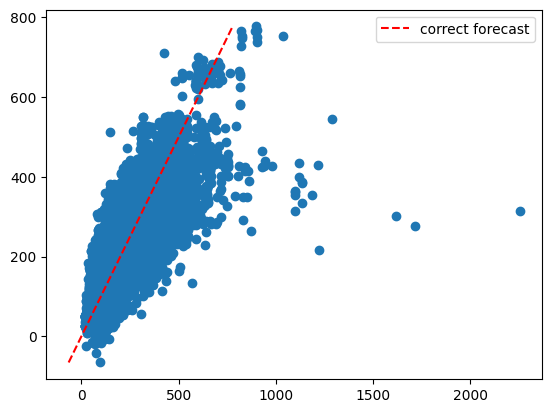

In [92]:
# PLOTTING RESULTS. Since the model is a multi-variate regression, if we want to visualize the results 
# we need to make a two-dimensional plot of points whose coordinates are (y_test , y_hat). 
# The more the points will be next to the y = x line, the more the predictor will be precise.


plt.scatter((y_test), (y_hat))

x = np.arange(min((y_hat)), max((y_hat)))
plt.plot(x, x, '--', c = 'r', label = 'correct forecast');
plt.legend()

plt.show()

Model Performance on Training Set: 99.99
Model Performance on Test Set: 100.0


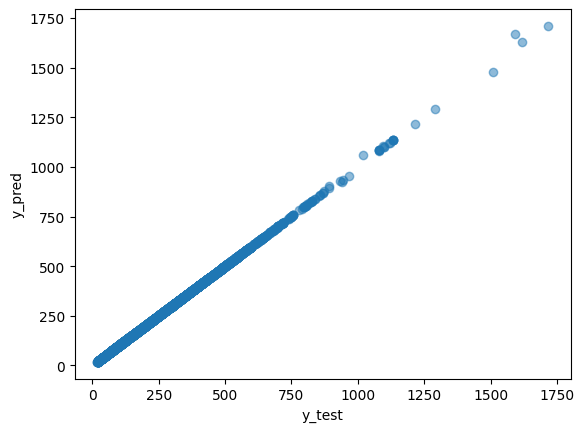

MAE: 0.01954614121510655
MSE: 0.601851146141215
RMSE: 0.7757906587096902
Normalized RMSE  0.0
Max Value:  2253 
Min Value:  18


In [94]:
from sklearn.model_selection import train_test_split
from sklearn import metrics  # Aggiungi questa linea
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Model training
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

# Model R2 on Training & Test
print('Model Performance on Training Set:', round(rf_reg.score(X_train, y_train)*100,2))
print('Model Performance on Test Set:', round(rf_reg.score(X_test, y_test)*100,2))

# Plot performance graph
y_pred = rf_reg.predict(X_test)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Model Error Values
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# RMSE = sqrt((PV-OV)^2/n)
print('Normalized RMSE ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/(max(y_test)-min(y_test)),2))
# RMSE/(max(DV)-min(DV))
print('Max Value: ', max(y), '\nMin Value: ', min(y))

# Save model pkl back to project folder
# import pickle
# # open a file, where you ant to store the data
# file = open('c1_flight_rf.pkl', 'wb')
# # dump information to that file
# pickle.dump(rf_reg, file)